In [1]:
import torch

from reggae.data_loaders.datasets import P53Data
from reggae.gp.variational import SingleLinearLFM, TranscriptionalTrainer
from reggae.utilities import save, load
from reggae.plot.variational_plotters import Plotter

from matplotlib import pyplot as plt
import numpy as np

f64 = np.float64


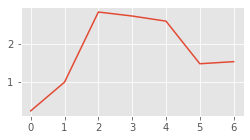

In [2]:
dataset = P53Data()

num_genes = len(dataset)

num_tfs = 1

t_inducing = torch.linspace(0, 1, 7, dtype=torch.float64).reshape((-1, 1))
t_observed = torch.linspace(0, 1, 7).view(-1)

m_observed = torch.stack([
    dataset[i][1] for i in range(num_genes)
])

plt.figure(figsize=(4, 2))
plt.plot(dataset[0][1])

In [3]:
#ExponentialLFM
model = SingleLinearLFM(num_genes, num_tfs,
                        t_inducing, dataset, extra_points=2,
                        fixed_variance=dataset.variance, learn_inducing=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
trainer = TranscriptionalTrainer(model, optimizer, dataset, batch_size=5)

C:\Users\Jacob\Documents\proj\reggae\reggae\gp\variational\models\model.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.inducing_inputs = Parameter(torch.tensor(t_inducing), requires_grad=learn_inducing)


### Outputs prior to training:

C:\Users\Jacob\Documents\proj\reggae\reggae\plot\variational_plotters.py:103: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(plotnum)


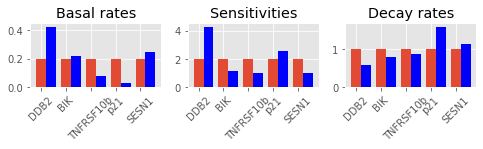

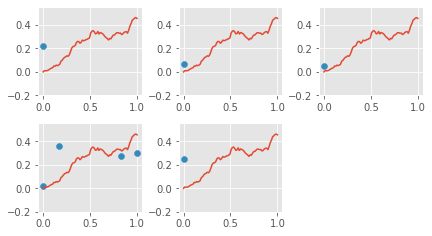

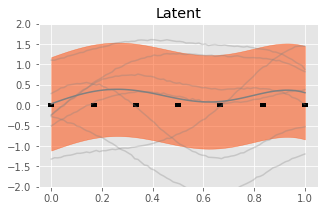

In [4]:
plotter = Plotter(model, dataset.gene_names)

t_predict = torch.linspace(f64(0), f64(1), 80, dtype=torch.float64)

rtol = 1e-3
atol = rtol/10

model_kwargs = {
    'rtol': rtol, 'atol': atol,
    'num_samples': 1
}

plotter.plot_kinetics()
plotter.plot_outputs(t_predict, t_scatter=t_observed,y_scatter=m_observed, model_kwargs=model_kwargs)
plotter.plot_latents(t_predict)

In [ ]:
tol = 1e-2
import time
start = time.time()

output = trainer.train(50, rtol=tol, atol=tol/10,
                       report_interval=5, plot_interval=20, num_samples=3)
end = time.time()
print(end - start)

Epoch 101/150 - Loss: 110.73 (104.39 6.34) λ: 0.025 b: 1.03 d 1.68 s: 2.94


### Outputs after training

C:\Users\Jacob\Documents\proj\reggae\reggae\plot\variational_plotters.py:103: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(plotnum)


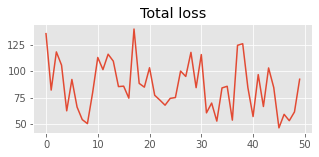

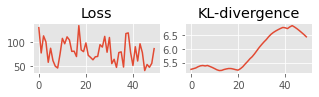

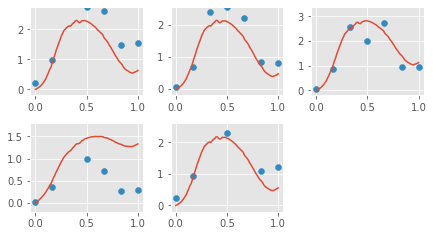

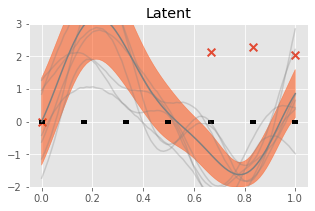

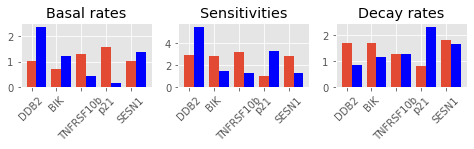

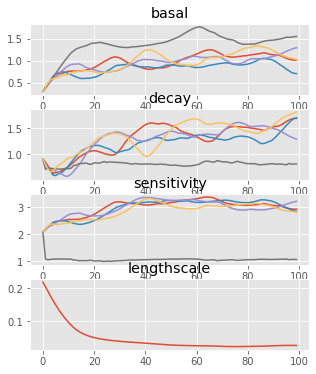

In [6]:

plotter.plot_losses(trainer)
plotter.plot_outputs(t_predict, t_scatter=t_observed,y_scatter=m_observed, model_kwargs=model_kwargs)
plotter.plot_latents(t_predict, ylim=(-2, 3), plot_barenco=True, plot_inducing=False)
plotter.plot_kinetics()
plotter.plot_convergence(trainer)

In [7]:
save(model, 'variational_linear')

In [8]:
do_load = False
if do_load:
    model = load('variational_linear', SingleLinearLFM, num_genes, num_tfs,
                 t_inducing, dataset, extra_points=2, fixed_variance=dataset.variance)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    trainer = TranscriptionalTrainer(model, optimizer, dataset, batch_size=5)
print(do_load)

False
